# rendering 

EXAMPLE 1: Classic Eden model (no clusters) with central seed
Final occupation: 4001 sites


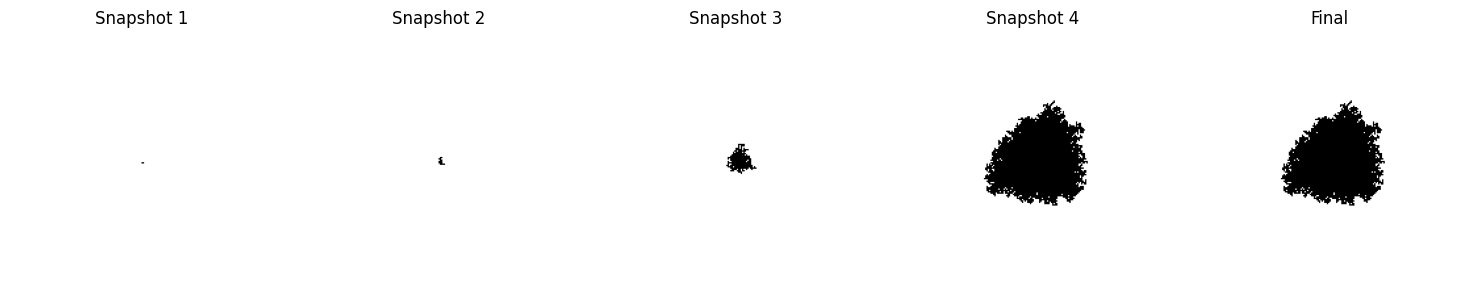


EXAMPLE 2: Eden with acceleration clusters (central seed)
Final occupation: 4129 sites
Acceleration cluster sites: 1360 sites


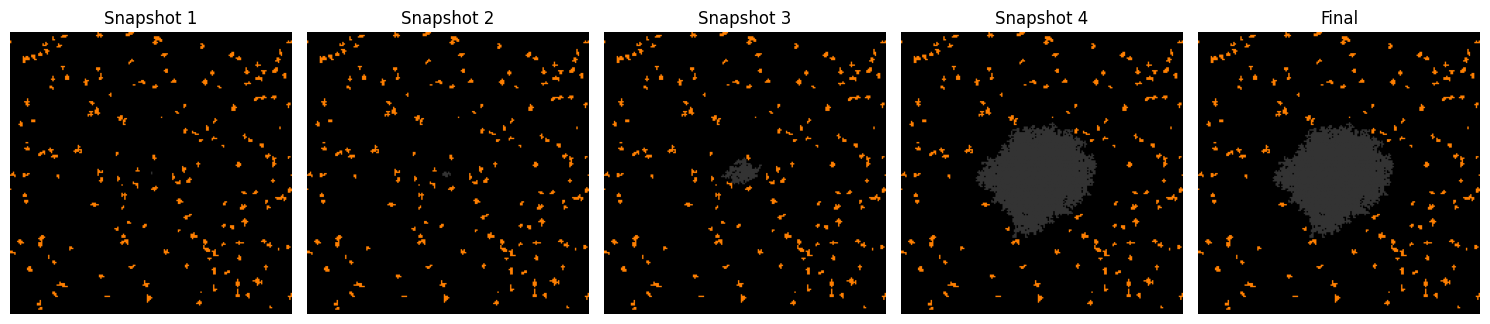


EXAMPLE 3: Eden with both acceleration and constraint clusters
Final occupation: 2886 sites
Acceleration cluster sites: 18152 sites
Constraint cluster sites: 2548 sites


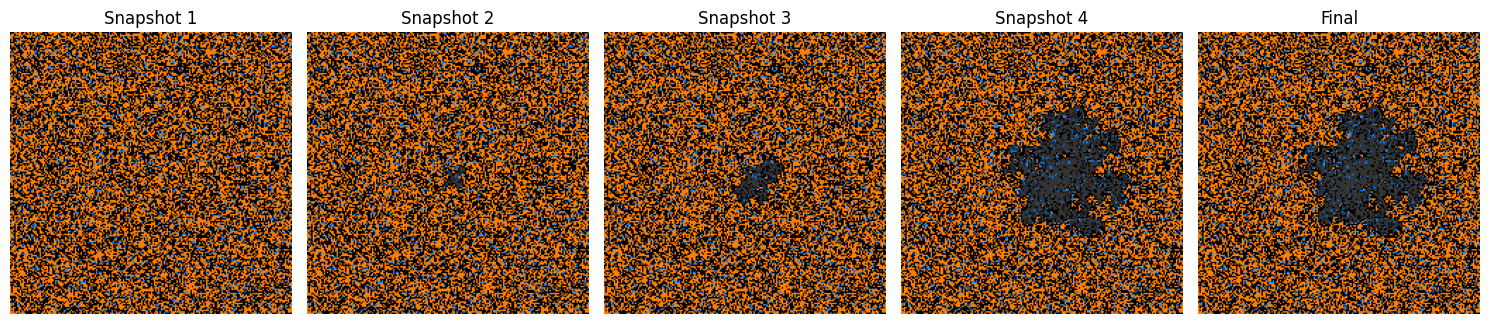


EXAMPLE 4: Multiple realizations with central seed and clusters


In [ ]:
import numpy as np
from numba import jit, prange
from numba.typed import List
import matplotlib.pyplot as plt

# ============================================================================
# INITIALIZATION FUNCTIONS
# ============================================================================
@jit(nopython=True)
def initialize_flat(width, height):
    """Initialize with flat bottom row."""
    lattice = np.zeros((height, width), dtype=np.int32)
    lattice[-1, :] = 1
    return lattice

@jit(nopython=True)
def initialize_central_seed(width, height):
    """Initialize with a single seed in the center."""
    lattice = np.zeros((height, width), dtype=np.int32)
    center_i = height // 2
    center_j = width // 2
    lattice[center_i, center_j] = 1
    return lattice

@jit(nopython=True)
def initialize_rough(width, height, roughness_height, seed=None):
    """Initialize with random roughness on top of bottom row."""
    if seed is not None:
        np.random.seed(seed)
    lattice = np.zeros((height, width), dtype=np.int32)
    for j in range(width):
        h = np.random.randint(1, roughness_height + 1)
        for i in range(height - h, height):
            lattice[i, j] = 1
    return lattice

# ============================================================================
# CLUSTER PLACEMENT WITH RUGOSITY CONTROL
# ============================================================================
@jit(nopython=True)
def place_clusters_with_labels(width, height, avg_cluster_size, probability, lattice, seed=None):
    """Place clusters and label each site with its cluster ID."""
    if seed is not None:
        np.random.seed(seed)
    acc_sites = np.zeros((height, width), dtype=np.int32)
    cluster_labels = np.zeros((height, width), dtype=np.int32)
    cluster_list = List()
    cluster_list.append(np.zeros((0, 2), dtype=np.int32))
    cluster_id = 1
    max_cluster_size = avg_cluster_size * 10
    
    for i in range(height):
        for j in range(width):
            if np.random.random() < probability and acc_sites[i, j] == 0 and lattice[i, j] == 0:
                cluster_size = max(1, int(avg_cluster_size + np.random.randn() * np.sqrt(float(avg_cluster_size))))
                cluster_positions = np.zeros((max_cluster_size, 2), dtype=np.int32)
                cluster_positions[0, 0] = i
                cluster_positions[0, 1] = j
                acc_sites[i, j] = 1
                cluster_labels[i, j] = cluster_id
                placed = 1
                
                cluster_i = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_j = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_i[0] = i
                cluster_j[0] = j
                cluster_count = 1
                attempts = 0
                boundary_count = 1
                center_i = float(i)
                center_j = float(j)
                max_attempts = cluster_size * 10
                
                while placed < cluster_size and attempts < max_attempts and boundary_count > 0:
                    attempts += 1
                    idx = np.random.randint(0, cluster_count)
                    ci = cluster_i[idx]
                    cj = cluster_j[idx]
                    
                    neighbor_i = np.array([ci-1, ci+1, ci, ci], dtype=np.int32)
                    neighbor_j = np.array([cj, cj, cj-1, cj+1], dtype=np.int32)
                    available = np.zeros(4, dtype=np.int32)
                    n_available = 0
                    
                    for n_idx in range(4):
                        ni = neighbor_i[n_idx]
                        nj = neighbor_j[n_idx] % width
                        if 0 <= ni < height and acc_sites[ni, nj] == 0 and lattice[ni, nj] == 0:
                            available[n_available] = n_idx
                            n_available += 1
                    
                    if n_available > 0:
                        pick = np.random.randint(0, n_available)
                        n_idx = available[pick]
                        ni = neighbor_i[n_idx]
                        nj = neighbor_j[n_idx] % width
                        
                        acc_sites[ni, nj] = 1
                        cluster_labels[ni, nj] = cluster_id
                        cluster_positions[placed, 0] = ni
                        cluster_positions[placed, 1] = nj
                        cluster_i[cluster_count] = ni
                        cluster_j[cluster_count] = nj
                        cluster_count += 1
                        boundary_count += 1
                        placed += 1
                        
                        center_i = (center_i * (placed - 1) + ni) / placed
                        center_j = (center_j * (placed - 1) + nj) / placed
                
                cluster_positions_actual = cluster_positions[:placed].copy()
                cluster_list.append(cluster_positions_actual)
                cluster_id += 1
    
    if cluster_id > 1:
        parent = np.arange(cluster_id, dtype=np.int32)
        rank = np.zeros(cluster_id, dtype=np.int32)
        
        def find(x):
            root = x
            while parent[root] != root:
                root = parent[root]
            while x != root:
                nxt = parent[x]
                parent[x] = root
                x = nxt
            return root
        
        def union(x, y):
            px = find(x)
            py = find(y)
            if px != py:
                if rank[px] > rank[py]:
                    parent[py] = px
                elif rank[px] < rank[py]:
                    parent[px] = py
                else:
                    parent[py] = px
                    rank[px] += 1
        
        for ii in range(height):
            for jj in range(width):
                if cluster_labels[ii, jj] > 0:
                    nj_right = (jj + 1) % width
                    if cluster_labels[ii, nj_right] > 0 and cluster_labels[ii, jj] != cluster_labels[ii, nj_right]:
                        union(cluster_labels[ii, jj], cluster_labels[ii, nj_right])
                    if ii + 1 < height and cluster_labels[ii + 1, jj] > 0 and cluster_labels[ii, jj] != cluster_labels[ii + 1, jj]:
                        union(cluster_labels[ii, jj], cluster_labels[ii + 1, jj])
        
        for k in range(1, cluster_id):
            parent[k] = find(k)
        
        for ii in range(height):
            for jj in range(width):
                if cluster_labels[ii, jj] > 0:
                    cluster_labels[ii, jj] = parent[cluster_labels[ii, jj]]
        
        has_label = np.zeros(cluster_id, dtype=np.int32)
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    has_label[lbl] = 1
        
        new_num_clusters = 0
        label_map = np.zeros(cluster_id, dtype=np.int32)
        for lbl in range(1, cluster_id):
            if has_label[lbl] == 1:
                new_num_clusters += 1
                label_map[lbl] = new_num_clusters
        
        for ii in range(height):
            for jj in range(width):
                if cluster_labels[ii, jj] > 0:
                    cluster_labels[ii, jj] = label_map[cluster_labels[ii, jj]]
        
        sizes = np.zeros(new_num_clusters + 1, dtype=np.int32)
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    sizes[lbl] += 1
        
        new_cluster_list = List()
        new_cluster_list.append(np.zeros((0, 2), dtype=np.int32))
        counters = np.zeros(new_num_clusters + 1, dtype=np.int32)
        
        for new_id in range(1, new_num_clusters + 1):
            pos = np.zeros((sizes[new_id], 2), dtype=np.int32)
            new_cluster_list.append(pos)
        
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    pos = new_cluster_list[lbl]
                    idx = counters[lbl]
                    pos[idx, 0] = ii
                    pos[idx, 1] = jj
                    counters[lbl] += 1
        
        cluster_list = new_cluster_list
    
    return acc_sites, cluster_labels, cluster_list

@jit(nopython=True)
def place_constraint_clusters(width, height, avg_cluster_size, probability, lattice, acc_sites, seed=None):
    """Place constraint clusters."""
    if seed is not None:
        np.random.seed(seed)
    con_sites = np.zeros((height, width), dtype=np.int32)
    max_cluster_size = avg_cluster_size * 10
    
    for i in range(height):
        for j in range(width):
            if np.random.random() < probability and con_sites[i, j] == 0 and acc_sites[i, j] == 0 and lattice[i, j] == 0:
                cluster_size = max(1, int(avg_cluster_size + np.random.randn() * np.sqrt(float(avg_cluster_size))))
                placed = 1
                con_sites[i, j] = 1
                
                cluster_i = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_j = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_i[0] = i
                cluster_j[0] = j
                cluster_count = 1
                attempts = 0
                max_attempts = cluster_size * 10
                
                while placed < cluster_size and attempts < max_attempts:
                    idx = np.random.randint(0, cluster_count)
                    ci = cluster_i[idx]
                    cj = cluster_j[idx]
                    
                    neighbor_i = np.array([ci-1, ci+1, ci, ci], dtype=np.int32)
                    neighbor_j = np.array([cj, cj, cj-1, cj+1], dtype=np.int32)
                    available = np.zeros(4, dtype=np.int32)
                    n_available = 0
                    
                    for n_idx in range(4):
                        ni = neighbor_i[n_idx]
                        nj = neighbor_j[n_idx] % width
                        if 0 <= ni < height and con_sites[ni, nj] == 0 and acc_sites[ni, nj] == 0 and lattice[ni, nj] == 0:
                            available[n_available] = n_idx
                            n_available += 1
                    
                    if n_available > 0:
                        pick = np.random.randint(0, n_available)
                        n_idx = available[pick]
                        ni = neighbor_i[n_idx]
                        nj = neighbor_j[n_idx] % width
                        
                        con_sites[ni, nj] = 1
                        cluster_i[cluster_count] = ni
                        cluster_j[cluster_count] = nj
                        cluster_count += 1
                        placed += 1
                    
                    attempts += 1
    
    return con_sites

# ============================================================================
# EDEN MODEL WITH CLUSTERS (CENTRAL OR BOTTOM SEED)
# ============================================================================
@jit(nopython=True)
def eden_model_with_clusters(width, height, n_iterations, snapshot_times, 
                             init_mode='central', roughness_height=5,
                             avg_cluster_size=5, probability=0.01,
                             acceleration_factor=2.0,
                             constraint_prob=0.0,
                             constraint_avg_cluster_size=5,
                             periodic_horizontal=True, periodic_vertical=False,
                             seed=None):
    """
    Eden model WITH acceleration and constraint clusters.
    Can start from central seed or bottom initialization.
    
    Parameters:
    -----------
    width : int
        Lattice width
    height : int
        Lattice height
    n_iterations : int
        Number of growth iterations
    snapshot_times : array
        Times at which to capture snapshots
    init_mode : str
        'central' for central seed, 'flat' for bottom row, 'rough' for rough bottom
    roughness_height : int
        Height variation for rough initialization
    avg_cluster_size : int
        Average size of acceleration clusters
    probability : float
        Probability of placing acceleration cluster at each site
    acceleration_factor : float
        Weight factor for acceleration clusters (e.g., 2.0 means 2x more likely)
    constraint_prob : float
        Probability of placing constraint clusters
    constraint_avg_cluster_size : int
        Average size of constraint clusters
    periodic_horizontal : bool
        Whether to use periodic boundary conditions horizontally
    periodic_vertical : bool
        Whether to use periodic boundary conditions vertically
    seed : int or None
        Random seed
        
    Returns:
    --------
    lattice : numpy.ndarray
        Final lattice (height, width)
    acc_sites : numpy.ndarray
        Acceleration cluster sites (height, width)
    con_sites : numpy.ndarray
        Constraint cluster sites (height, width)
    snapshots : numpy.ndarray
        Snapshots at specified times (n_snapshots, height, width)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Initialize lattice
    if init_mode == 'central':
        lattice = initialize_central_seed(width, height)
    elif init_mode == 'rough':
        lattice = initialize_rough(width, height, roughness_height, seed)
    else:
        lattice = initialize_flat(width, height)
    
    # Place acceleration and constraint clusters
    acc_sites, cluster_labels, cluster_list = place_clusters_with_labels(
        width, height, avg_cluster_size, probability, lattice, seed
    )
    
    con_sites = place_constraint_clusters(
        width, height, constraint_avg_cluster_size, constraint_prob, 
        lattice, acc_sites, seed
    )
    
    n_clusters = len(cluster_list)
    cluster_activated = np.zeros(n_clusters, dtype=np.int32)
    
    # Initialize boundary tracking
    is_boundary = np.zeros((height, width), dtype=np.int32)
    max_boundary_size = width * height
    boundary_i = np.zeros(max_boundary_size, dtype=np.int32)
    boundary_j = np.zeros(max_boundary_size, dtype=np.int32)
    boundary_count = 0
    
    acc_boundary_i = np.zeros(max_boundary_size, dtype=np.int32)
    acc_boundary_j = np.zeros(max_boundary_size, dtype=np.int32)
    acc_boundary_cluster = np.zeros(max_boundary_size, dtype=np.int32)
    acc_boundary_count = 0
    
    # Find initial boundary sites
    for i in range(height):
        for j in range(width):
            if lattice[i, j] == 0 and con_sites[i, j] == 0:
                has_occupied = False
                
                # Check up
                ni = i - 1
                if periodic_vertical:
                    ni = ni % height
                if (periodic_vertical or ni >= 0) and lattice[ni, j] == 1:
                    has_occupied = True
                
                # Check down
                ni = i + 1
                if periodic_vertical:
                    ni = ni % height
                if (periodic_vertical or ni < height) and lattice[ni, j] == 1:
                    has_occupied = True
                
                # Check left
                nj = j - 1
                if periodic_horizontal:
                    nj = nj % width
                if (periodic_horizontal or nj >= 0) and lattice[i, nj] == 1:
                    has_occupied = True
                
                # Check right
                nj = j + 1
                if periodic_horizontal:
                    nj = nj % width
                if (periodic_horizontal or nj < width) and lattice[i, nj] == 1:
                    has_occupied = True
                
                if has_occupied:
                    is_boundary[i, j] = 1
                    cell_cluster = cluster_labels[i, j]
                    
                    if cell_cluster > 0 and cluster_activated[cell_cluster] == 0:
                        # Check if cluster already in acceleration boundary
                        already_in = False
                        for k in range(acc_boundary_count):
                            if acc_boundary_cluster[k] == cell_cluster:
                                already_in = True
                                break
                        if not already_in:
                            acc_boundary_i[acc_boundary_count] = i
                            acc_boundary_j[acc_boundary_count] = j
                            acc_boundary_cluster[acc_boundary_count] = cell_cluster
                            acc_boundary_count += 1
                    else:
                        boundary_i[boundary_count] = i
                        boundary_j[boundary_count] = j
                        boundary_count += 1
    
    # Pre-allocate snapshots
    n_snapshots = len(snapshot_times)
    snapshots = np.zeros((n_snapshots, height, width), dtype=np.int32)
    snapshot_idx = 0
    
    # Growth iterations with cascades
    for iteration in range(n_iterations):
        # Capture snapshot
        if snapshot_idx < n_snapshots and iteration == snapshot_times[snapshot_idx]:
            snapshots[snapshot_idx] = lattice.copy()
            snapshot_idx += 1
        
        total_boundary = boundary_count + acc_boundary_count
        if total_boundary == 0:
            break
        
        # Weighted selection between normal sites and acceleration clusters
        total_weight = boundary_count + acc_boundary_count * acceleration_factor
        rand_val = np.random.random() * total_weight
        
        if rand_val < acc_boundary_count * acceleration_factor and acc_boundary_count > 0:
            # CASCADE: Select acceleration cluster
            idx = np.random.randint(0, acc_boundary_count)
            selected_cluster = acc_boundary_cluster[idx]
            cluster_sites = cluster_list[selected_cluster]
            
            # Occupy entire cluster
            for k in range(len(cluster_sites)):
                ci, cj = cluster_sites[k, 0], cluster_sites[k, 1]
                lattice[ci, cj] = 1
                is_boundary[ci, cj] = 0
            
            cluster_activated[selected_cluster] = 1
            
            # Remove from acceleration boundary
            acc_boundary_count -= 1
            if idx < acc_boundary_count:
                acc_boundary_i[idx] = acc_boundary_i[acc_boundary_count]
                acc_boundary_j[idx] = acc_boundary_j[acc_boundary_count]
                acc_boundary_cluster[idx] = acc_boundary_cluster[acc_boundary_count]
            
            # Add neighbors of all cluster sites
            for k in range(len(cluster_sites)):
                ci, cj = cluster_sites[k, 0], cluster_sites[k, 1]
                
                neighbors = [
                    (ci - 1, cj),
                    (ci + 1, cj),
                    (ci, cj - 1),
                    (ci, cj + 1)
                ]
                
                for ni_base, nj_base in neighbors:
                    ni = ni_base
                    nj = nj_base
                    
                    if periodic_vertical:
                        ni = ni % height
                    if periodic_horizontal:
                        nj = nj % width
                    
                    valid = True
                    if not periodic_vertical and (ni < 0 or ni >= height):
                        valid = False
                    if not periodic_horizontal and (nj < 0 or nj >= width):
                        valid = False
                    
                    if valid and lattice[ni, nj] == 0 and con_sites[ni, nj] == 0 and is_boundary[ni, nj] == 0:
                        # Check if has occupied neighbor
                        has_occ = False
                        for dni, dnj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            nni = ni + dni
                            nnj = nj + dnj
                            
                            if periodic_vertical:
                                nni = nni % height
                            if periodic_horizontal:
                                nnj = nnj % width
                            
                            check_valid = True
                            if not periodic_vertical and (nni < 0 or nni >= height):
                                check_valid = False
                            if not periodic_horizontal and (nnj < 0 or nnj >= width):
                                check_valid = False
                            
                            if check_valid and lattice[nni, nnj] == 1:
                                has_occ = True
                                break
                        
                        if has_occ:
                            is_boundary[ni, nj] = 1
                            nc = cluster_labels[ni, nj]
                            
                            if nc > 0 and cluster_activated[nc] == 0:
                                already = False
                                for m in range(acc_boundary_count):
                                    if acc_boundary_cluster[m] == nc:
                                        already = True
                                        break
                                if not already:
                                    acc_boundary_i[acc_boundary_count] = ni
                                    acc_boundary_j[acc_boundary_count] = nj
                                    acc_boundary_cluster[acc_boundary_count] = nc
                                    acc_boundary_count += 1
                            else:
                                boundary_i[boundary_count] = ni
                                boundary_j[boundary_count] = nj
                                boundary_count += 1
        
        else:
            # Normal site selection
            if boundary_count > 0:
                idx = np.random.randint(0, boundary_count)
                i, j = boundary_i[idx], boundary_j[idx]
                
                lattice[i, j] = 1
                is_boundary[i, j] = 0
                
                # Remove from boundary list
                boundary_count -= 1
                if idx < boundary_count:
                    boundary_i[idx] = boundary_i[boundary_count]
                    boundary_j[idx] = boundary_j[boundary_count]
                
                # Check neighbors and add new boundary sites
                neighbors = [
                    (i - 1, j),
                    (i + 1, j),
                    (i, j - 1),
                    (i, j + 1)
                ]
                
                for ni_base, nj_base in neighbors:
                    ni = ni_base
                    nj = nj_base
                    
                    if periodic_vertical:
                        ni = ni % height
                    if periodic_horizontal:
                        nj = nj % width
                    
                    valid = True
                    if not periodic_vertical and (ni < 0 or ni >= height):
                        valid = False
                    if not periodic_horizontal and (nj < 0 or nj >= width):
                        valid = False
                    
                    if valid and lattice[ni, nj] == 0 and con_sites[ni, nj] == 0 and is_boundary[ni, nj] == 0:
                        # Check if has occupied neighbor
                        has_occ = False
                        for dni, dnj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            nni = ni + dni
                            nnj = nj + dnj
                            
                            if periodic_vertical:
                                nni = nni % height
                            if periodic_horizontal:
                                nnj = nnj % width
                            
                            check_valid = True
                            if not periodic_vertical and (nni < 0 or nni >= height):
                                check_valid = False
                            if not periodic_horizontal and (nnj < 0 or nnj >= width):
                                check_valid = False
                            
                            if check_valid and lattice[nni, nnj] == 1:
                                has_occ = True
                                break
                        
                        if has_occ:
                            is_boundary[ni, nj] = 1
                            nc = cluster_labels[ni, nj]
                            
                            if nc > 0 and cluster_activated[nc] == 0:
                                already = False
                                for m in range(acc_boundary_count):
                                    if acc_boundary_cluster[m] == nc:
                                        already = True
                                        break
                                if not already:
                                    acc_boundary_i[acc_boundary_count] = ni
                                    acc_boundary_j[acc_boundary_count] = nj
                                    acc_boundary_cluster[acc_boundary_count] = nc
                                    acc_boundary_count += 1
                            else:
                                boundary_i[boundary_count] = ni
                                boundary_j[boundary_count] = nj
                                boundary_count += 1
    
    # Final snapshot if needed
    if snapshot_idx < n_snapshots and n_iterations == snapshot_times[snapshot_idx]:
        snapshots[snapshot_idx] = lattice.copy()
    
    return lattice, acc_sites, con_sites, snapshots

# ============================================================================
# PARALLEL EDEN MODEL WITH CLUSTERS
# ============================================================================
@jit(nopython=True, parallel=True)
def eden_model_with_clusters_parallel(width, height, n_iterations, snapshot_times,
                                     n_realizations, init_mode='central',
                                     roughness_height=5,
                                     avg_cluster_size=5, probability=0.01,
                                     acceleration_factor=2.0,
                                     constraint_prob=0.0,
                                     constraint_avg_cluster_size=5,
                                     periodic_horizontal=True,
                                     periodic_vertical=False,
                                     seed=None):
    """
    Parallel version of Eden model with clusters.
    
    Returns:
    --------
    lattices : numpy.ndarray
        Shape (n_realizations, height, width)
    acc_sites_all : numpy.ndarray
        Shape (n_realizations, height, width)
    con_sites_all : numpy.ndarray
        Shape (n_realizations, height, width)
    snapshots : numpy.ndarray
        Shape (n_realizations, n_snapshots, height, width)
    """
    n_snapshots = len(snapshot_times)
    lattices = np.zeros((n_realizations, height, width), dtype=np.int32)
    acc_sites_all = np.zeros((n_realizations, height, width), dtype=np.int32)
    con_sites_all = np.zeros((n_realizations, height, width), dtype=np.int32)
    snapshots = np.zeros((n_realizations, n_snapshots, height, width), dtype=np.int32)
    
    for r in prange(n_realizations):
        realization_seed = None if seed is None else seed + r
        lattices[r], acc_sites_all[r], con_sites_all[r], snapshots[r] = eden_model_with_clusters(
            width, height, n_iterations, snapshot_times,
            init_mode, roughness_height,
            avg_cluster_size, probability, acceleration_factor,
            constraint_prob, constraint_avg_cluster_size,
            periodic_horizontal, periodic_vertical,
            realization_seed
        )
    
    return lattices, acc_sites_all, con_sites_all, snapshots

# ============================================================================
# CLASSIC EDEN MODEL (NO CASCADES)
# ============================================================================
@jit(nopython=True)
def classic_eden_model(width, height, n_iterations, snapshot_times, 
                       init_mode='central', roughness_height=5,
                       periodic_horizontal=True, periodic_vertical=False,
                       seed=None):
    """
    Classic Eden model without acceleration clusters.
    
    Parameters:
    -----------
    width : int
        Lattice width
    height : int
        Lattice height
    n_iterations : int
        Number of growth iterations
    snapshot_times : array
        Times at which to capture snapshots
    init_mode : str
        'central' for central seed, 'flat' for bottom row, 'rough' for rough bottom
    roughness_height : int
        Height variation for rough initialization
    periodic_horizontal : bool
        Whether to use periodic boundary conditions horizontally
    periodic_vertical : bool
        Whether to use periodic boundary conditions vertically
    seed : int or None
        Random seed
        
    Returns:
    --------
    lattice : numpy.ndarray
        Final lattice (height, width)
    snapshots : numpy.ndarray
        Snapshots at specified times (n_snapshots, height, width)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Initialize lattice
    if init_mode == 'central':
        lattice = initialize_central_seed(width, height)
    elif init_mode == 'rough':
        lattice = initialize_rough(width, height, roughness_height, seed)
    else:
        lattice = initialize_flat(width, height)
    
    # Initialize boundary tracking
    is_boundary = np.zeros((height, width), dtype=np.int32)
    max_boundary_size = width * height
    boundary_i = np.zeros(max_boundary_size, dtype=np.int32)
    boundary_j = np.zeros(max_boundary_size, dtype=np.int32)
    boundary_count = 0
    
    # Find initial boundary sites
    for i in range(height):
        for j in range(width):
            if lattice[i, j] == 0:
                has_occupied = False
                
                # Check up
                ni = i - 1
                if periodic_vertical:
                    ni = ni % height
                if (periodic_vertical or ni >= 0) and lattice[ni, j] == 1:
                    has_occupied = True
                
                # Check down
                ni = i + 1
                if periodic_vertical:
                    ni = ni % height
                if (periodic_vertical or ni < height) and lattice[ni, j] == 1:
                    has_occupied = True
                
                # Check left
                nj = j - 1
                if periodic_horizontal:
                    nj = nj % width
                if (periodic_horizontal or nj >= 0) and lattice[i, nj] == 1:
                    has_occupied = True
                
                # Check right
                nj = j + 1
                if periodic_horizontal:
                    nj = nj % width
                if (periodic_horizontal or nj < width) and lattice[i, nj] == 1:
                    has_occupied = True
                
                if has_occupied:
                    is_boundary[i, j] = 1
                    boundary_i[boundary_count] = i
                    boundary_j[boundary_count] = j
                    boundary_count += 1
    
    # Pre-allocate snapshots
    n_snapshots = len(snapshot_times)
    snapshots = np.zeros((n_snapshots, height, width), dtype=np.int32)
    snapshot_idx = 0
    
    # Growth iterations
    for iteration in range(n_iterations):
        # Capture snapshot
        if snapshot_idx < n_snapshots and iteration == snapshot_times[snapshot_idx]:
            snapshots[snapshot_idx] = lattice.copy()
            snapshot_idx += 1
        
        if boundary_count == 0:
            break
        
        # Select random boundary site
        idx = np.random.randint(0, boundary_count)
        i, j = boundary_i[idx], boundary_j[idx]
        
        # Occupy the site
        lattice[i, j] = 1
        is_boundary[i, j] = 0
        
        # Remove from boundary list
        boundary_count -= 1
        if idx < boundary_count:
            boundary_i[idx] = boundary_i[boundary_count]
            boundary_j[idx] = boundary_j[boundary_count]
        
        # Check neighbors and add new boundary sites
        neighbors = [
            (i - 1, j),  # up
            (i + 1, j),  # down
            (i, j - 1),  # left
            (i, j + 1)   # right
        ]
        
        for ni_base, nj_base in neighbors:
            ni = ni_base
            nj = nj_base
            
            # Apply periodic boundary conditions
            if periodic_vertical:
                ni = ni % height
            if periodic_horizontal:
                nj = nj % width
            
            # Check if neighbor is valid and unoccupied
            valid = True
            if not periodic_vertical and (ni < 0 or ni >= height):
                valid = False
            if not periodic_horizontal and (nj < 0 or nj >= width):
                valid = False
            
            if valid and lattice[ni, nj] == 0 and is_boundary[ni, nj] == 0:
                # Check if this neighbor has an occupied neighbor
                has_occ = False
                
                # Check neighbor's neighbors
                for dni, dnj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nni = ni + dni
                    nnj = nj + dnj
                    
                    if periodic_vertical:
                        nni = nni % height
                    if periodic_horizontal:
                        nnj = nnj % width
                    
                    check_valid = True
                    if not periodic_vertical and (nni < 0 or nni >= height):
                        check_valid = False
                    if not periodic_horizontal and (nnj < 0 or nnj >= width):
                        check_valid = False
                    
                    if check_valid and lattice[nni, nnj] == 1:
                        has_occ = True
                        break
                
                if has_occ:
                    is_boundary[ni, nj] = 1
                    boundary_i[boundary_count] = ni
                    boundary_j[boundary_count] = nj
                    boundary_count += 1
    
    # Final snapshot if needed
    if snapshot_idx < n_snapshots and n_iterations == snapshot_times[snapshot_idx]:
        snapshots[snapshot_idx] = lattice.copy()
    
    return lattice, snapshots
@jit(nopython=True, parallel=True)
def classic_eden_model_parallel(width, height, n_iterations, snapshot_times,
                                n_realizations, init_mode='central',
                                roughness_height=5,
                                periodic_horizontal=True,
                                periodic_vertical=False,
                                seed=None):
    """
    Parallel version of classic Eden model.
    
    Returns:
    --------
    lattices : numpy.ndarray
        Shape (n_realizations, height, width)
    snapshots : numpy.ndarray
        Shape (n_realizations, n_snapshots, height, width)
    """
    n_snapshots = len(snapshot_times)
    lattices = np.zeros((n_realizations, height, width), dtype=np.int32)
    snapshots = np.zeros((n_realizations, n_snapshots, height, width), dtype=np.int32)
    
    for r in prange(n_realizations):
        realization_seed = None if seed is None else seed + r
        lattices[r], snapshots[r] = classic_eden_model(
            width, height, n_iterations, snapshot_times,
            init_mode, roughness_height,
            periodic_horizontal, periodic_vertical,
            realization_seed
        )
    
    return lattices, snapshots

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================
def generate_log_times(n_iterations, n_snapshots):
    """Generate logarithmically spaced snapshot times."""
    return np.unique(np.logspace(0, np.log10(n_iterations), n_snapshots, dtype=np.int32))

def generate_linear_times(n_iterations, n_snapshots):
    """Generate linearly spaced snapshot times."""
    return np.linspace(0, n_iterations, n_snapshots, dtype=np.int32)

# ============================================================================
# VISUALIZATION EXAMPLE
# ============================================================================
def visualize_eden_with_clusters(lattice, acc_sites, con_sites, snapshots=None, figsize=(15, 4)):
    """Visualize Eden growth results with clusters."""
    if snapshots is not None:
        n_snapshots = snapshots.shape[0]
        fig, axes = plt.subplots(1, n_snapshots + 1, figsize=figsize)
        
        for i, snap in enumerate(snapshots):
            # Create RGB image
            img = np.zeros((snap.shape[0], snap.shape[1], 3))
            img[snap == 1] = [0.2, 0.2, 0.2]  # Occupied sites
            img[acc_sites == 1] = [1.0, 0.5, 0.0]  # Acceleration clusters (orange)
            img[con_sites == 1] = [0.0, 0.5, 1.0]  # Constraint clusters (blue)
            img[snap == 1] = [0.2, 0.2, 0.2]  # Occupied sites on top
            
            axes[i].imshow(img, origin='lower')
            axes[i].set_title(f'Snapshot {i+1}')
            axes[i].axis('off')
        
        # Final state
        img = np.zeros((lattice.shape[0], lattice.shape[1], 3))
        img[lattice == 1] = [0.2, 0.2, 0.2]
        img[acc_sites == 1] = [1.0, 0.5, 0.0]
        img[con_sites == 1] = [0.0, 0.5, 1.0]
        img[lattice == 1] = [0.2, 0.2, 0.2]
        
        axes[-1].imshow(img, origin='lower')
        axes[-1].set_title('Final')
        axes[-1].axis('off')
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
        img = np.zeros((lattice.shape[0], lattice.shape[1], 3))
        img[lattice == 1] = [0.2, 0.2, 0.2]
        img[acc_sites == 1] = [1.0, 0.5, 0.0]
        img[con_sites == 1] = [0.0, 0.5, 1.0]
        img[lattice == 1] = [0.2, 0.2, 0.2]
        
        ax.imshow(img, origin='lower')
        ax.set_title('Eden Growth with Clusters')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# EXAMPLE USAGE
# ============================================================================
if __name__ == "__main__":
    # Parameters
    width = 200
    height = 200
    n_iterations = 4000
    n_snapshots = 4
    
    # Generate snapshot times
    snapshot_times = generate_log_times(n_iterations, n_snapshots)
    
    print("=" * 70)
    print("EXAMPLE 1: Classic Eden model (no clusters) with central seed")
    print("=" * 70)
    lattice, snapshots = classic_eden_model(
        width=width,
        height=height,
        n_iterations=n_iterations,
        snapshot_times=snapshot_times,
        init_mode='central',
        periodic_horizontal=True,
        periodic_vertical=False,
        seed=42
    )
    print(f"Final occupation: {np.sum(lattice)} sites")
    
    # Visualize
    fig, axes = plt.subplots(1, n_snapshots + 1, figsize=(15, 3))
    for i, snap in enumerate(snapshots):
        axes[i].imshow(snap, cmap='binary', origin='lower')
        axes[i].set_title(f'Snapshot {i+1}')
        axes[i].axis('off')
    axes[-1].imshow(lattice, cmap='binary', origin='lower')
    axes[-1].set_title('Final')
    axes[-1].axis('off')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("EXAMPLE 2: Eden with acceleration clusters (central seed)")
    print("=" * 70)
    lattice2, acc_sites, con_sites, snapshots2 = eden_model_with_clusters(
        width=width,
        height=height,
        n_iterations=n_iterations,
        snapshot_times=snapshot_times,
        init_mode='central',
        avg_cluster_size=8,
        probability=0.005,
        acceleration_factor=3.0,
        constraint_prob=0.0,
        periodic_horizontal=True,
        periodic_vertical=False,
        seed=42
    )
    print(f"Final occupation: {np.sum(lattice2)} sites")
    print(f"Acceleration cluster sites: {np.sum(acc_sites)} sites")
    
    # Visualize with clusters
    visualize_eden_with_clusters(lattice2, acc_sites, con_sites, snapshots2)
    
    print("\n" + "=" * 70)
    print("EXAMPLE 3: Eden with both acceleration and constraint clusters")
    print("=" * 70)
    lattice3, acc_sites3, con_sites3, snapshots3 = eden_model_with_clusters(
        width=200,
        height=200,
        n_iterations=1000,
        snapshot_times=generate_log_times(1000, 4),
        init_mode='central',
        avg_cluster_size=1,
        probability=0.4,
        acceleration_factor=100,
        constraint_prob=0.1,
        constraint_avg_cluster_size=1,
        periodic_horizontal=True,
        periodic_vertical=False,
        seed=42
    )
    print(f"Final occupation: {np.sum(lattice3)} sites")
    print(f"Acceleration cluster sites: {np.sum(acc_sites3)} sites")
    print(f"Constraint cluster sites: {np.sum(con_sites3)} sites")
    
    # Visualize
    visualize_eden_with_clusters(lattice3, acc_sites3, con_sites3, snapshots3)
    
    print("\n" + "=" * 70)
    print("EXAMPLE 4: Multiple realizations with central seed and clusters")
    print("=" * 70)
    n_realizations = 4
    lattices, acc_all, con_all, all_snapshots = eden_model_with_clusters_parallel(
        width=150,
        height=150,
        n_iterations=5000,
        snapshot_times=generate_log_times(5000, 3),
        n_realizations=n_realizations,
        init_mode='central',
        avg_cluster_size=7,
        probability=0.01,
        acceleration_factor=2.0,
        constraint_prob=0.002,
        seed=42
    )
    
    # Visualize all realizations (final states)
    fig, axes = plt.subplots(1, n_realizations, figsize=(16, 4))
    for i in range(n_realizations):
        img = np.zeros((lattices[i].shape[0], lattices[i].shape[1], 3))
        img[lattices[i] == 1] = [0.2, 0.2, 0.2]
        img[acc_all[i] == 1] = [1.0, 0.5, 0.0]
        img[con_all[i] == 1] = [0.0, 0.5, 1.0]
        img[lattices[i] == 1] = [0.2, 0.2, 0.2]
        
        axes[i].imshow(img, origin='lower')
        axes[i].set_title(f'Realization {i+1}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Average final occupation: {np.mean([np.sum(l) for l in lattices]):.1f} sites")

In [2]:
#observe beta for 10^6 iterations and width of 10^4
########## PARAMETERS #############


n_iterations=1500000
n_realizations=150
width = 1000
height= int((n_iterations/width)*5)
print(f"height:{height}")
n_snapshots= 40
avg_cluster_size=1
probabilities=[0]
probabilities=np.array(probabilities)/avg_cluster_size
# probabilities=[0,0.0005,0.001,0.005,0.00625]

print(f"probabilities:{probabilities}")


#  n_iterations=1000000
# n_realizations=100
# width = 1400
# height= int((n_iterations/width)*5)
# print(f"height:{height}")
# n_snapshots= 30
# probabilities=[0,0.000001,0.000005,0.00001]




snapshots_col=[]  
# Create array for logtimes
lin_t=generate_log_times(n_iterations=n_iterations,n_snapshots=n_snapshots)

constraint_avg_cluster_size=0
rugosity=1

print(lin_t)



height:7500
probabilities:[0.]
[      1       2       4       6       8      12      18      26      38
      55      79     114     164     237     341     492     708    1020
    1469    2116    3047    4388    6319    9099   13103   18869   27171
   39127   56342   81133  116832  168237  242261  348855  502351  723383
 1041669 1500000]


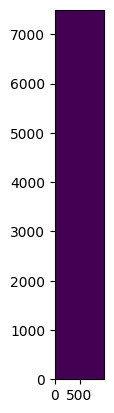

In [3]:
import matplotlib.pyplot as plt
lattice = np.zeros((height, width), dtype=np.int32)

acc_sites, cluster_labels, cluster_list = place_clusters_with_labels(
    width, height, avg_cluster_size,probabilities[-1], lattice)

plt.figure()
plt.imshow(cluster_labels,origin='lower')

In [4]:
for probability in probabilities:
    

    
#Simulate the system
 
    lattices,acceleration_sites,constraint_sites,snapshots,densities =eden_model_cascade_snapshots_parallel(width=width,height=height,n_iterations=n_iterations,snapshot_times=lin_t,
                                                               n_realizations=n_realizations,init_mode='flat',roughness_height=0,seed=42,
                                                               avg_cluster_size=avg_cluster_size,probability=probability ,acceleration_factor=5.0,
                                                               constraint_avg_cluster_size=0,constraint_prob=0,eden_sites=False)

    snapshots_avg=np.mean(snapshots,axis=0)
    snapshots_col.append(snapshots_avg)
    

1
38


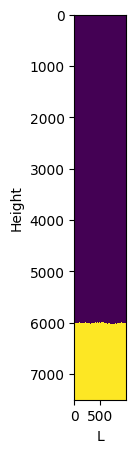

In [5]:
#### Visualize the growth
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.imshow(lattices[-1], interpolation='nearest')
plt.xlabel("L")
plt.ylabel("Height")


print(len(snapshots_col))
print(len(snapshots_avg))


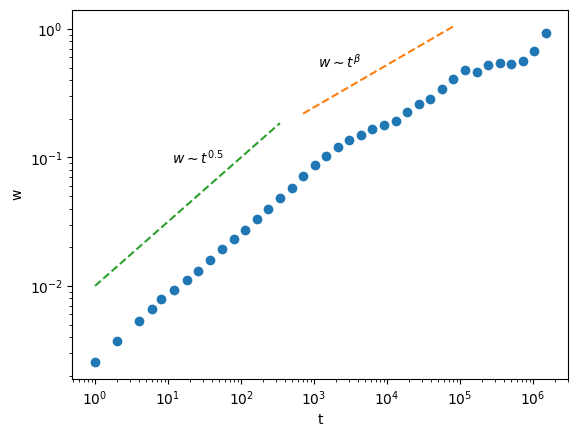

[0.]
[np.float64(0.3201132505340229)]


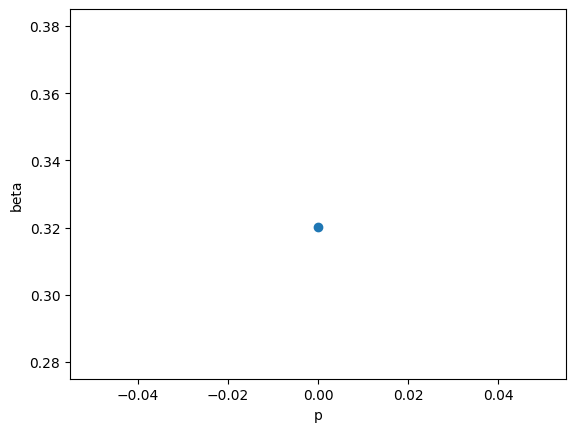

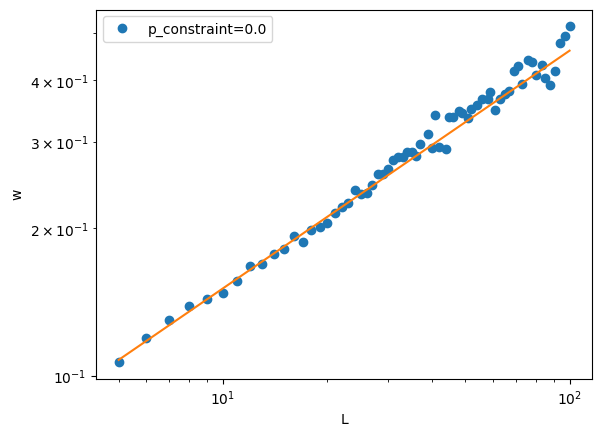

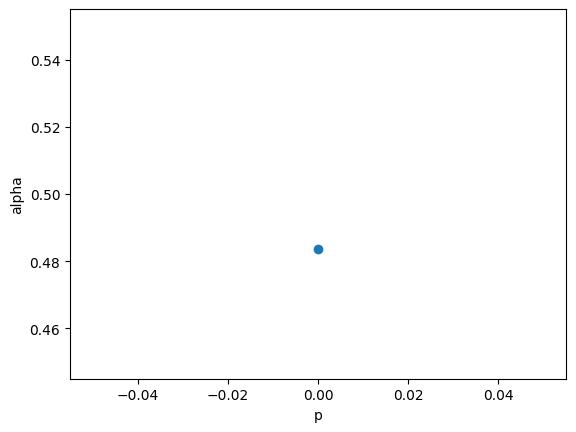

[np.float64(0.48374318872599786)]


In [14]:
#plot the exponents
import numpy as np
w_col=[]
w=[]




for i in range(len(probabilities)):
    for j in range((n_snapshots)-2):
        w.append(np.std(snapshots_col[i][j]))
    w_col.append(w)
    w=[]

   


res_col=[]

plt.figure()
for i in range(len(probabilities)):
    plt.loglog(lin_t[:],w_col[i][:],'o')
    res=np.polyfit(np.log10(lin_t[19:30]),np.log10(w_col[i][19:30]),1)
   # plt.loglog(lin_t[19:30],10**(np.log10((lin_t[19:30]))*res[0]+res[1]))
    res_col.append(res[0])
    plt.xlabel('t')
    plt.ylabel('w')


plt.loglog(lin_t[16:-8],10**(np.log10((lin_t[16:-8]))*0.33-1.6),'--',label='beta=0.33')
plt.loglog(lin_t[0:15],10**(np.log10((lin_t[0:15]))*0.5-2),'--',label='beta=0.5')
plt.text(1000, 0.5, r' $w \sim t^{\beta}$', fontsize=10)
plt.text(10, 0.09, r' $w \sim t^{0.5}$', fontsize=10)


plt.show()
print(probabilities)
print(res_col)

plt.figure()
plt.plot(probabilities[:],res_col[:],'o')
plt.plot(probabilities[:],0.28*np.ones((len(probabilities[:]),1)),'--')
plt.plot(probabilities[:],0.38*np.ones((len(probabilities[:]),1)),'--')
plt.plot(probabilities[:],0.33*np.ones((len(probabilities[:]),1)))
plt.xlabel('p')
plt.ylabel('beta')



def compute_avg_std_devs(array, num_points=10):
    """
    Compute the average standard deviation for logarithmically spaced section sizes l.
    
    Parameters:
    - array: 1D numpy array of length L
    - num_points: number of l values to generate (including endpoints)
    
    Returns:
    - l_values: array of l values (sorted)
    - avg_stds: array of average std devs for each l
    """
    L = len(array)
    l_min = 5
    l_max = L // 10
    
    if l_max < l_min:
        raise ValueError(f"L/4 ({l_max}) is less than l_min ({l_min}). Increase L or adjust l_min.")
    
    # Generate logarithmically spaced l values, unique and integer
    l_values = np.unique(np.logspace(np.log10(l_min), np.log10(l_max), num_points, dtype=int))
    
    avg_stds = []
    for l in l_values:
        stds = []
        for i in range(0,L - l + 1,l):
            sector = array[i:i+l]
            stds.append(np.std(sector))
        avg_stds.append(np.mean(stds))
    
    return l_values, np.array(avg_stds)

res_collection=[]
w_avg=[]





plt.figure()
for i in range(len(probabilities)):
    x = np.arange(len(snapshots_col[i][-1]))  # Spatial coordinates

    l,w=compute_avg_std_devs(snapshots_col[i][-1],num_points=100)
    
    plt.loglog(l,w,'o',label=f"p_constraint={probabilities[i]}")
    res=np.polyfit(np.log10(l[0:25]),np.log10(w[0:25]),1)
    res_collection.append(res[0])

    
    plt.loglog(l,10**(np.log10(l)*res[0]+res[1]))
plt.xlabel("L")
plt.ylabel('w')
plt.legend()
plt.show()




plt.figure()
plt.plot(probabilities[:],res_collection[:],'o')
plt.plot(probabilities[:],0.5*np.ones((len(probabilities[:]),1)))
plt.plot(probabilities[:],0.55*np.ones((len(probabilities[:]),1)),'--')
plt.plot(probabilities[:],0.45*np.ones((len(probabilities[:]),1)),'--')
plt.xlabel("p")
plt.ylabel('alpha')
plt.show()

print(res_collection)

